# Project 01: one protein against many ligands 

The purpose is to find interaction hotspots in a single target through the analysis of interactions found in a dataset of diverse small compounds.

This was used in the prototype pipeline to elucidate hotspots in the sars-cov-19 protease, and we will refine it here against other datasets.

The workflow itself consists of three steps:

1. Obtaining and sanitizing the data
2. Ingesting it in `plipify`
3. Generating publication-worthy figures

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import requests
r = requests.get(f"https://fragalysis.diamond.ac.uk/api/targets/?format=json")
r.raise_for_status()
targets = [t["title"] for t in r.json()["results"] if t["zip_archive"]]
print("Downloadable targets:", *targets)

Downloadable targets: NUDT7A ATAD BRD1A DCP2B FAM83BA MURD NUDT4A OXA10OTA PARP14A PHIPA PTP1B SMTGR ACVR1A ATAD2A CAMK1DA DCLRE1AA FALZA HAO1A MUREECA NUDT21A NUDT4 NUDT5A NUDT7A_CRUDE smTGRNEW STAG1A TBXTA VIM2 XX02KALRNA TNCA ALAS2A EPB41L3A mArh INPP5DA nsp13 Mac1 Mpro NSP15_B MUREECOLI PGN_RS02895PGA


In [3]:
from pathlib import Path

TARGET = "Mpro"  # other options, see above

HERE = Path(_dh[-1])
DATA = HERE / "data" / TARGET
OUT = HERE / "output" / TARGET
DATA.mkdir(exist_ok=True, parents=True)
OUT.mkdir(exist_ok=True, parents=True)

## Obtaining and sanitizing the data

We will be using data from [_Fragalysis_](), a XRC platform that generates structures for ligand collections against a given target. API endpoint is described [here](https://fragalysis.diamond.ac.uk/api/?format=api), but in short, it seems that you can download a full featured zip file using this URL: `https://fragalysis.diamond.ac.uk/media/targets/$TARGETNAME.zip`.

In [4]:
r = requests.get(f"https://fragalysis.diamond.ac.uk/api/targets/?format=json&title={TARGET}")
r.raise_for_status()
target = r.json()["results"][0]

if target["zip_archive"] is None:
    raise ValueError(f"Target {TARGET} is not downloadable")

,crystal_name,RealCrystalName,smiles,new_smiles,alternate_name,site_name,pdb_entry,ROMol
1,Mpro-x11271_0A,Mpro-x11271,COC=1C=C(Cl)C=C(CC(=O)NC=2C=NC=CC2C)C1,NaN,MAT-POS-c9973a83-1,Aminopyridine-like,NaN,
2,Mpro-x11041_0A,Mpro-x11041,CN(C(=O)CC=1C=CC=C(Cl)C1)C=2C=NC=CC2C,NaN,JAN-GHE-83b26c96-15,Aminopyridine-like,NaN,
3,Mpro-x1002_0A,Mpro-x1002,OC=1C=CC=CN1,NaN,AAR-POS-0daf6b7e-37,XChem Screen - xtal contact,5RF4,
4,Mpro-x10155_0A,Mpro-x10155,CC(N1CCN(Cc2cnc(Cc3ccccc3)s2)CC1)=O,CC(N1CCN(Cc2cnc(Cc3ccccc3)s2)CC1)=O,MED-COV-4280ac29-25,Chloroacetamide,NaN,
6,Mpro-x1101_1A,Mpro-x1101,CC(C)N(C)C=1N=CN=C2N(C)N=CC12,NaN,AAR-POS-0daf6b7e-40,XChem Screen - xtal contact,5RGR,
...,...,...,...,...,...,...,...,...
1175,Mpro-P0039_0B,Mpro-P0039,NC[C@]1(CCOC=2C=CC(Cl)=CC21)C(=O)NC=3C=NC=C4C=...,NC[C@]1(CCOC=2C=CC(Cl)=CC21)C(=O)NC=3C=NC=C4C=...,EDG-MED-971238d3-5,Isoquinoline,NaN,
1176,Mpro-x10535_0A,Mpro-x10535,Cl.ClC=1C=CC=C(C1)N2C(=O)NC(C2=O)C=3C=CC=NC3,ClC=1C=CC=C(C1)N2C(=O)NC(C2=O)C=3C=CC=NC3,JAN-GHE-83b26c96-18,Aminopyridine-like,NaN,
1177,Mpro-P0240_0A,Mpro-P0240,ClC=1C=CC=2CNCC(C(=O)NC=3C=NC=C4C=CC=CC34)C2C1,ClC=1C=CC=2CNCC(C(=O)NC=3C=NC=C4C=CC=CC34)C2C1,BEN-DND-f2e727cd-5,Isoquinoline,NaN,
1178,Mpro-x12716_0A,Mpro-x12716,Cl.Cl.NC[C@]1(CCOC=2C=CC(Cl)=CC21)C(=O)NC=3C=N...,NC[C@]1(CCOC=2C=CC(Cl)=CC21)C(=O)NC=3C=NC=C4C=...,EDG-MED-971238d3-5,Isoquinoline,NaN,

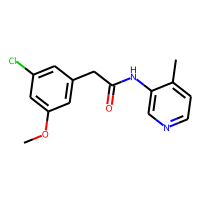
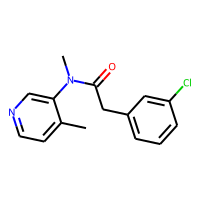
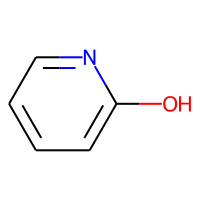
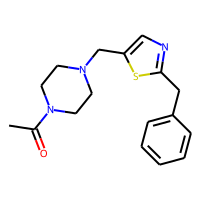
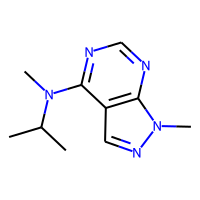
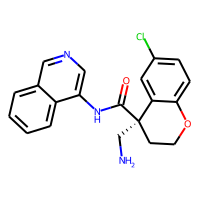
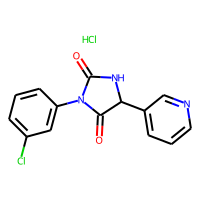
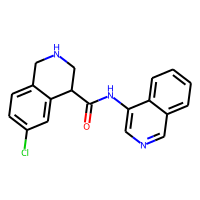
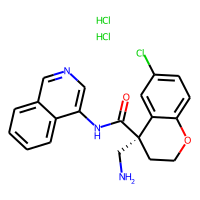
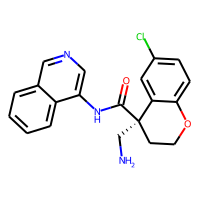

In [5]:
import pandas as pd
from rdkit.Chem.PandasTools import AddMoleculeColumnToFrame

metadata = requests.get(target["metadata"], stream=True)
metadata = pd.read_csv(metadata.raw, index_col=0)
AddMoleculeColumnToFrame(metadata, smilesCol="smiles")
metadata

Prealigned PDBs for each row can be found in `data/{target}/aligned/{crystal_name}/{crystal_name}_bound.pdb`:

In [6]:
from io import BytesIO
from zipfile import ZipFile

# If already downloaded, they should be here:
pdbs = list((DATA / "aligned").glob("**/*_bound.pdb"))

if not pdbs:
    archive =  requests.get(target["zip_archive"], stream=True)
    with BytesIO(archive.raw.data) as b, ZipFile(b) as z:
        z.extractall(DATA)
    # Reassign now
    pdbs = list((DATA / "aligned").glob("**/*_bound.pdb"))
    assert pdbs, "Couldn't find downloaded PDB structures!"

As the directory name suggests, these are prealigned:

In [7]:
import nglview as nv

view = nv.NGLWidget()
for pdb in pdbs[:10]:
    structure = nv.adaptor.FileStructure(str(pdb))
    comp = view.add_component(structure, default_representation=False)
    comp.add_cartoon()
    comp.add_ball_and_stick("LIG")
view.center("LIG")
view

NGLWidget()

In [8]:
view.render_image(factor=1, trim=True, transparent=True, antialias=True);

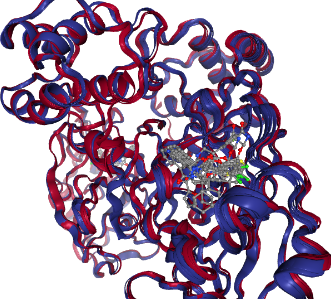

In [9]:
view._display_image()

Notice how binding sites are not always the same.

### tmp: Split files by chain

In [10]:
from Bio.PDB import *

print(pdbs[0])

for nr, filepath in enumerate(pdbs):
    pdb_id = str(pdbs[nr]).split('/')[-1][:-4]
    chain_id = str(pdbs[nr]).split('/')[-1].split('_')[1][-1]
    new_filename=str(pdbs[nr])[:-4]+'_chain'+str(chain_id)+'.pdb'
    
    ## Read the PDB file and extract the chain from structure[0]
    model = PDBParser(PERMISSIVE=1,QUIET=1).get_structure(pdb_id, filepath)[0]
    ### Save new file
    io = PDBIO()
    io.set_structure(model[chain_id])
    io.save(new_filename)
print (nr)

/home/andrea/devel/py/plipify/projects/01/data/Mpro/aligned/Mpro-P0008_0A/Mpro-P0008_0A_bound.pdb
492


Update the pdb list to pdb chain list

In [11]:
pdbs = list((DATA / "aligned").glob("**/*_bound_chain*.pdb"))
print(pdbs[0:3])

[PosixPath('/home/andrea/devel/py/plipify/projects/01/data/Mpro/aligned/Mpro-P0008_0A/Mpro-P0008_0A_bound_chainA.pdb'), PosixPath('/home/andrea/devel/py/plipify/projects/01/data/Mpro/aligned/Mpro-P0008_0B/Mpro-P0008_0B_bound_chainB.pdb'), PosixPath('/home/andrea/devel/py/plipify/projects/01/data/Mpro/aligned/Mpro-P0009_0A/Mpro-P0009_0A_bound_chainA.pdb')]


Check structures

In [12]:
import nglview as nv

view = nv.NGLWidget()
for pdb in pdbs[:10]:
    structure = nv.adaptor.FileStructure(str(pdb))
    comp = view.add_component(structure, default_representation=False)
    comp.add_cartoon()
    comp.add_ball_and_stick("LIG")
view.center("LIG")
view

NGLWidget()

## Ingesting it in `plipify` 

TBD.

In [13]:
from plipify.core import Structure
from plipify.fingerprints import InteractionFingerprint
from tqdm.auto import tqdm

In [14]:
structures = []
for path in tqdm(pdbs):
    structure = Structure.from_pdbfile(str(path), ligand_name="LIG")
    if len(structure.binding_sites) != 1:
        print(f"{path.relative_to(HERE)} contains {len(structure.binding_sites)} binding sites and we want exactly one.")
        continue
    structures.append(structure)

  0%|          | 0/493 [00:00<?, ?it/s]

data/Mpro/aligned/Mpro-x1101_0A/Mpro-x1101_0A_bound_chainA.pdb contains 2 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-x1101_1A/Mpro-x1101_1A_bound_chainA.pdb contains 2 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-x12025_0A/Mpro-x12025_0A_bound_chainA.pdb contains 2 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-x12025_1A/Mpro-x12025_1A_bound_chainA.pdb contains 2 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-z2zu2_0A/Mpro-z2zu2_0A_bound_chainA.pdb contains 0 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-z2zu2_0B/Mpro-z2zu2_0B_bound_chainB.pdb contains 0 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-z2zu2_1A/Mpro-z2zu2_1A_bound_chainA.pdb contains 0 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-z4ylu_0A/Mpro-z4ylu_0A_bound_chainA.pdb contains 0 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-z4ylu_0B/Mpro-z4ylu_0B_bound_chainB.pdb contains 0 binding sites and 

### Rudimentary filter to exclude artifacts (by sequence length deviation)

In [15]:
import pandas as pd
lengths = pd.DataFrame([((s.identifier), len(s.sequence())) for s in structures], columns=["identifier", "length"])
# Remove entries where the difference sequence length - median sequence length is greater than one standard deviation
print('Sequence length median and std: ',lengths.length.median(),lengths.length.std() )

Sequence length median and std:  304.0 1.3704707370361833


In [16]:
lengths = lengths[(lengths.length - lengths.length.median()).abs() < lengths.length.std()]
filtered_structures = [s for s in structures if s.identifier in set(lengths.identifier.tolist())]
print(len(pdbs), "->", len(structures), "->", len(filtered_structures), "=", len(pdbs) - len(filtered_structures), "structures filtered out")

structures = filtered_structures

493 -> 466 -> 395 = 98 structures filtered out


In [17]:
from importlib import reload
import plipify.fingerprints, plipify.core, plipify.visualization
reload(plipify.fingerprints)
reload(plipify.core)
reload(plipify.visualization)
from plipify.fingerprints import InteractionFingerprint

### tmp fix: it seemed like the problem only occured in the 'MPro-P...' structures, so expluding them for now.
To avoid error when generating interatcion fingerprints `ValueError: Length mismatch: Expected axis has 296 elements, new values have 305 element`

In [18]:
# count type of structures
structure_name_type_dict={'Mpro-P':0, 'Mpro-x':0, 'Mpro-z':0, 'other':0}
print(structure_name_type_dict.keys())
for s in structures:
    name_code = s.identifier[0:6]
    if name_code in structure_name_type_dict.keys():
        structure_name_type_dict[name_code]+=1
    else:
        structure_name_type_dict['other']+=1
print(structure_name_type_dict)

dict_keys(['Mpro-P', 'Mpro-x', 'Mpro-z', 'other'])
{'Mpro-P': 35, 'Mpro-x': 359, 'Mpro-z': 1, 'other': 0}


In [19]:
# exclude 35 Mpro-P structures
filtered_structures = [s for s in structures if not (s.identifier.startswith('Mpro-P'))]
print('remaining: ',len(filtered_structures), 'from:', len(structures))
structures = filtered_structures

remaining:  360 from: 395


In [ ]:
# Review
fp = InteractionFingerprint().calculate_fingerprint(
        structures,
        labeled=True, 
        as_dataframe=True, 
        remove_non_interacting_residues=True,
        remove_empty_interaction_types=True,
        ensure_same_sequence=False
    )

if not fp.values.shape[0]:
    raise ValueError("Fingerprint is empty!")

In [ ]:
fp.style.background_gradient(axis=None, cmap="YlGnBu")

This fingerprint is too sparse, let's try to focus on the hotspots only (arbitrarily defined now as "residue with more than 10 total interactions, regardless the type")

In [ ]:
fp_focused = fp[fp.sum(axis=1) > 10]

In [ ]:
fp_focused.style.background_gradient(axis=None, cmap="YlGnBu")

In [ ]:
from plipify.visualization import fingerprint_barplot, fingerprint_heatmap, fingerprint_table, fingerprint_nglview

In [ ]:
fingerprint_barplot(fp_focused)

In [ ]:
fingerprint_heatmap(fp_focused, cmap="YlGnBu");

In [ ]:
fingerprint_table(fp_focused)

In [ ]:
view = fingerprint_nglview(fp_focused, structures[1])
view.center("LIG")
view

In [ ]:
view.render_image(factor=1, trim=True, transparent=True, antialias=True);

In [ ]:
view._display_image()

In [ ]:
structures[0].to_dataframes()

In [ ]:
structures[0].view()

## Generating publication-worthy figures

TBD.